In [218]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## 1) Importing Data 

In [219]:
sp500=yf.download('^GSPC',start="2021-03-05", end="2023-03-01",interval='1h')

[*********************100%***********************]  1 of 1 completed


In [220]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
2021-03-05 09:30:00,3793.580078,3808.010010,3762.540039,3765.350098,3765.350098,0
2021-03-05 10:30:00,3765.310059,3773.090088,3730.409912,3734.860107,3734.860107,506513782
2021-03-05 11:30:00,3739.770020,3785.830078,3738.469971,3784.429932,3784.429932,395114999
2021-03-05 12:30:00,3784.379883,3813.830078,3779.969971,3811.649902,3811.649902,331342864
2021-03-05 13:30:00,3811.929932,3823.260010,3804.300049,3821.479980,3821.479980,288925337


<AxesSubplot:>

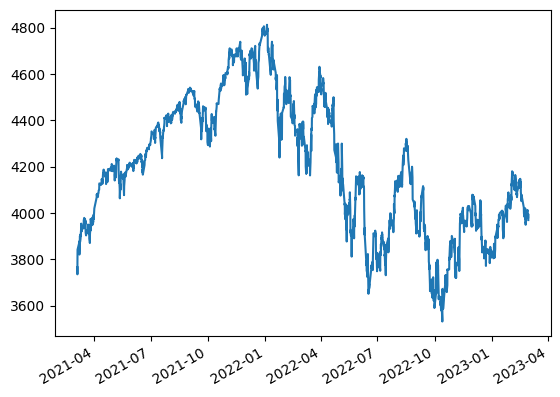

In [221]:
sp500['Adj Close'].plot()

<AxesSubplot:>

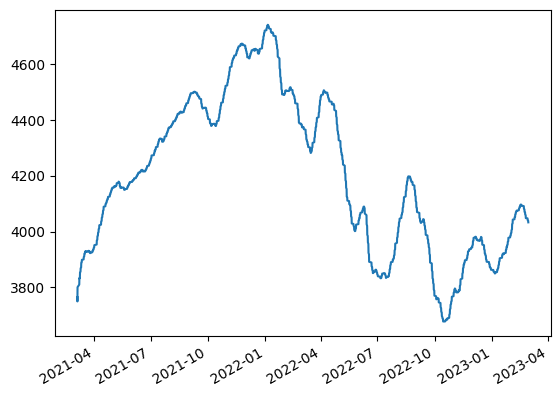

In [222]:
sp500['Adj Close'].ewm(span=100).mean().plot()

In [223]:
sp500['Adj Close']=sp500['Adj Close'].ewm(span=100).mean()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [224]:
sp500.shape

(3494, 6)

Figure(640x480)


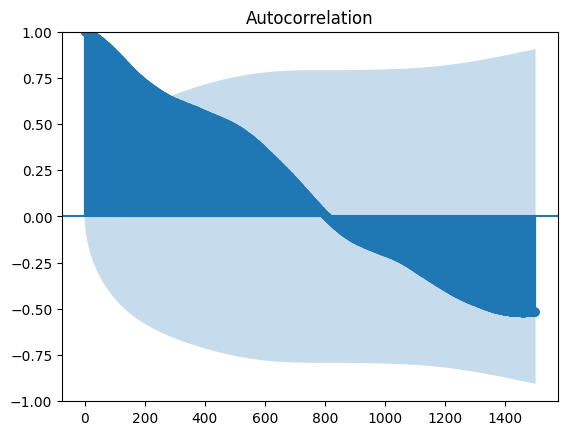

In [225]:
print(plot_acf(sp500['Adj Close'],lags=1500))

Also autocorrelation graph shows no seasonal pattern.

## 2) Decomposition of Data 

In [275]:
sp500_decomposition = seasonal_decompose(x=sp500['Adj Close'], model='additive', period=125)

### 2.1) Trend 

<AxesSubplot:>

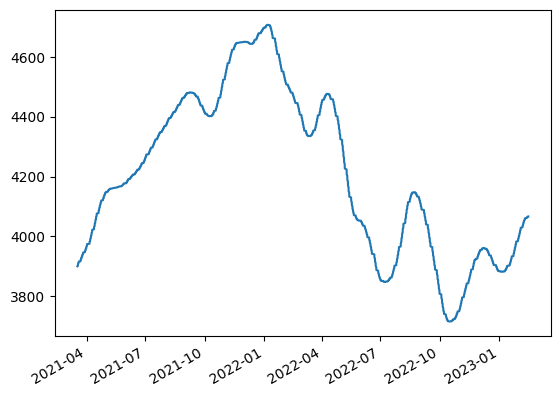

In [276]:
sp500_decomposition.trend.plot()

### 2.2) Seasonal 

<AxesSubplot:>

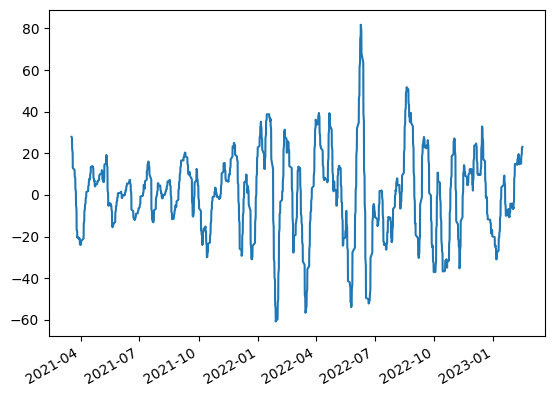

In [277]:
(sp500_decomposition.seasonal+sp500_decomposition.resid).plot()

<AxesSubplot:>

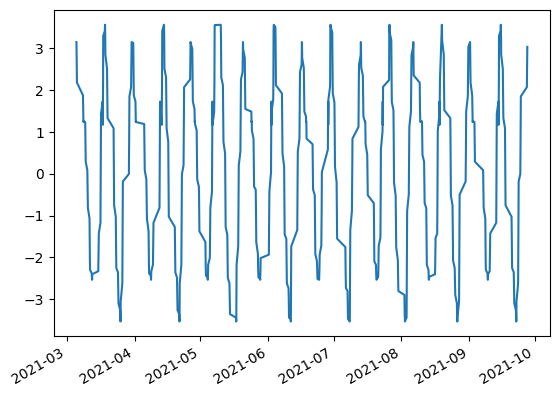

In [278]:
sp500_decomposition.seasonal[:1000].plot()

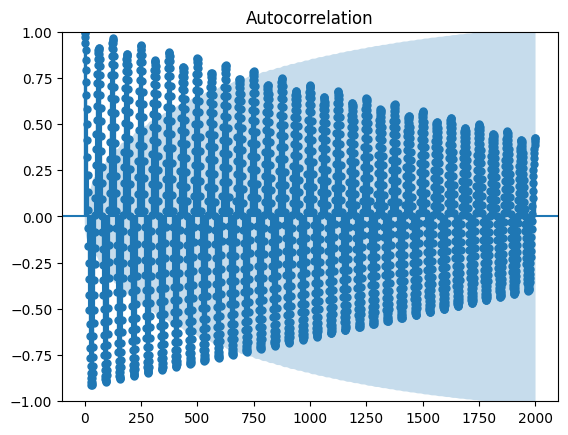

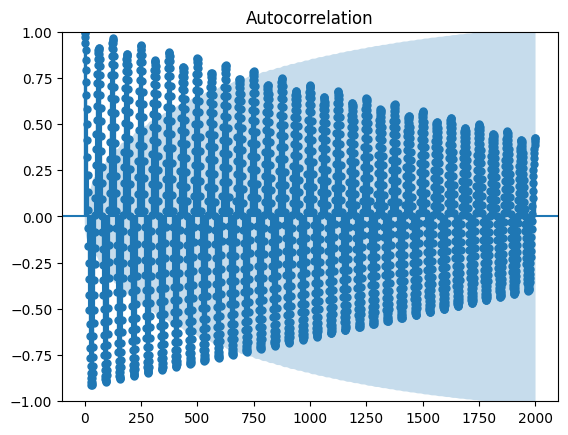

In [279]:
plot_acf(sp500_decomposition.seasonal,lags=2000)

### 2.3) Residual 

<AxesSubplot:>

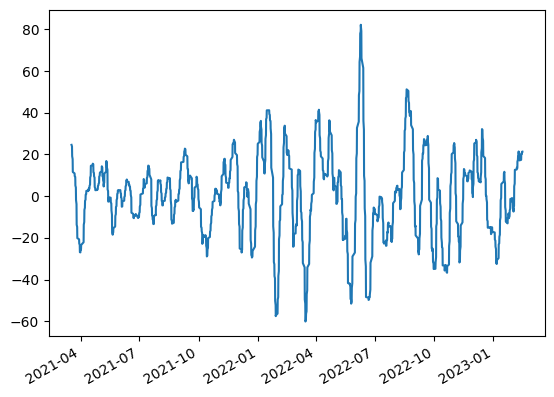

In [280]:
sp500_decomposition.resid.dropna().plot()

## 3) Stationarity Test

<AxesSubplot:>

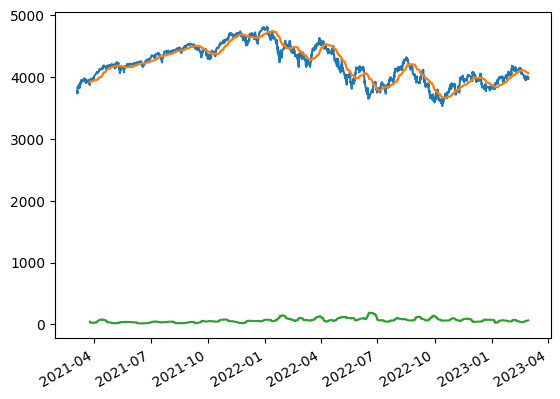

In [201]:
sp500['Adj Close'].plot()
sp500['Adj Close'].rolling(100).mean().plot()
sp500['Adj Close'].rolling(100).std().plot()

### 3.1) Constant Mean Test

In [202]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).mean().max() - sp500['Adj Close'].rolling(500).mean().min() ) * 100 / sp500['Adj Close'].rolling(500).mean().max()
# The mean appears to be constant considering the value of mean, since the difference between minimum and max is about 17% from it's max value

17.32152416258564

In [203]:
# chunks = np.split(monthly_temp.temp, indices_or_sections=12)

### 3.2) Constant Std Test

In [204]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).std().max() - sp500['Adj Close'].rolling(500).std().min() ) * 100 / sp500['Adj Close'].rolling(500).std().max()
# the standard deviation is not constant

76.9273954730576

### 3.3) Dickey Fuller Test 

In [205]:
adf_sp500, pvalue_sp500, usedlag_, nobs_, critical_values_sp500, icbest_ = adfuller(sp500['Adj Close'])
pvalue_sp500

0.2896839176397715

The pvalue of dickey fuller should be below 0.05. <br>
The next dickey fuller test would be conducted on a data after removing autocorrelation with differencing. 

In [206]:
sp500_diff=sp500['Adj Close'].diff(periods=1)[~np.isnan(sp500['Adj Close'].diff(periods=1))]
adf_sp500_diff, pvalue_sp500_diff, usedlag_diff, nobs_diff, critical_values_sp500, icbest_diff = adfuller(sp500_diff)
pvalue_sp500_diff

0.0

The value is lower than 0.05 so, the stationary test is passed.

<AxesSubplot:>

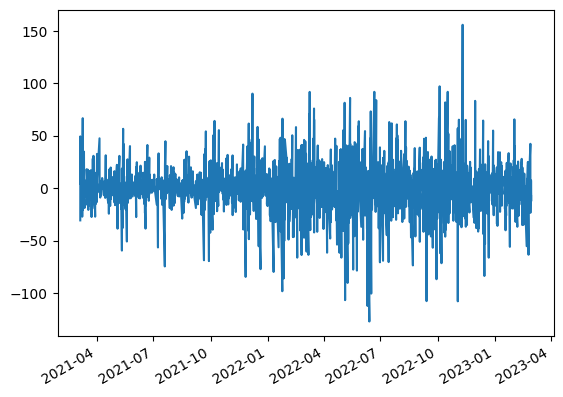

In [207]:
sp500_diff.plot()

### 3.4) Autocorrelation Tests 

Figure(640x480)
Figure(640x480)


C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


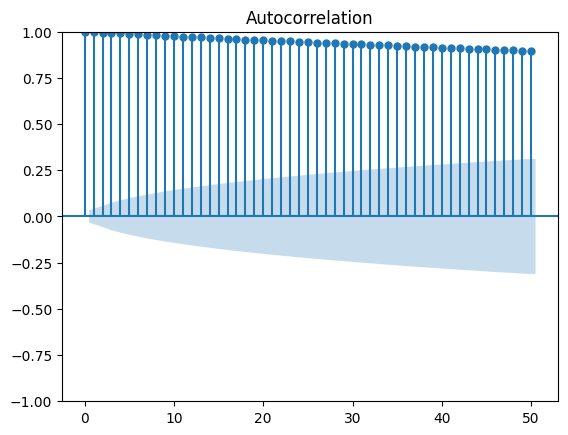

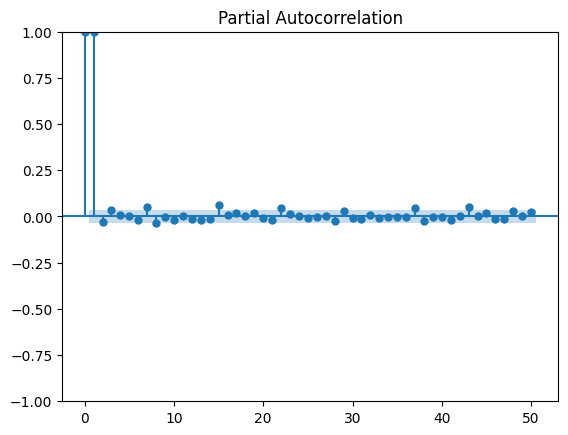

In [208]:
print(plot_acf(sp500['Adj Close'],lags=50))
print(plot_pacf(sp500['Adj Close'],lags=50))

In [209]:
# difference data

Figure(640x480)
Figure(640x480)


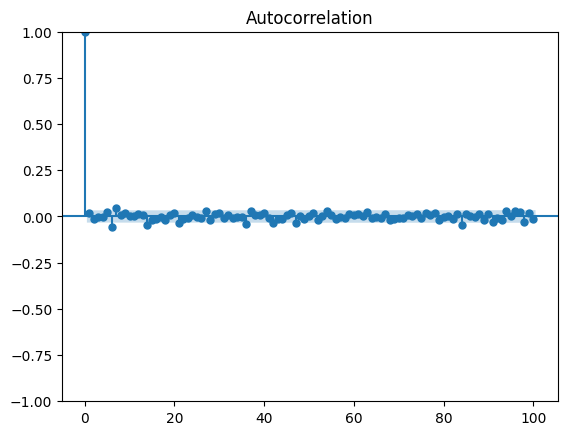

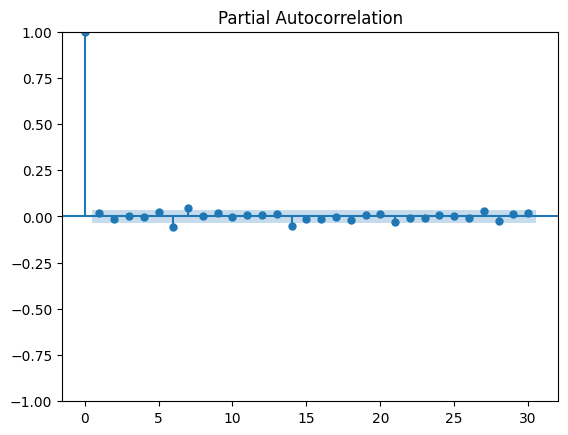

In [210]:
print(plot_acf(sp500_diff,lags=20))
print(plot_pacf(sp500_diff,lags=20))

## 4) Model

In [211]:
sp500['Adj Close'].iloc[:3400]

2021-03-05 09:30:00    3765.350098
2021-03-05 10:30:00    3734.860107
2021-03-05 11:30:00    3784.429932
2021-03-05 12:30:00    3811.649902
2021-03-05 13:30:00    3821.479980
                          ...     
2023-02-07 15:30:00    4164.069824
2023-02-08 09:30:00    4145.779785
2023-02-08 10:30:00    4119.669922
2023-02-08 11:30:00    4128.930176
2023-02-08 12:30:00    4129.040039
Name: Adj Close, Length: 3400, dtype: float64

In [281]:
sar = sm.tsa.statespace.SARIMAX(sp500['Adj Close'].iloc[1:3400], 
                                order=(2,1,2), 
                                seasonal_order=(0,1,1,125), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inverti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                             Adj Close   No. Observations:                 3399
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 125)   Log Likelihood               -1801.570
Date:                               Sat, 04 Mar 2023   AIC                           3617.140
Time:                                       12:49:59   BIC                           3659.794
Sample:                                            0   HQIC                          3632.415
                                              - 3399                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.002     -1.352      0.176      -0.005       0.001
ar.L1          0.1740      0.095      1.824      0.068      -0.013       0.361
ar.L2          0.7953      0.094      8.502      0.000       0.612       0.979
ma.L1          0.8274      0.098      8.415      0.000       0.635       1.020
ma.L2         -0.0144      0.017     -0.831      0.406      -0.048       0.020
ma.S.L125     -0.9621      0.023    -42.393      0.000      -1.007      -0.918
sigma2         0.1603      0.003     49.594      0.000       0.154       0.167
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              7764.65
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

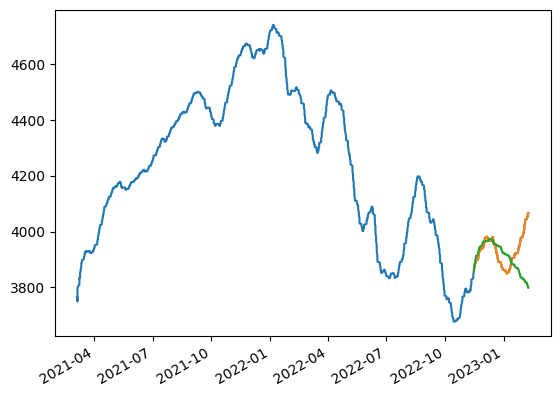

In [282]:
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
 

sp500['Adj Close'].iloc[:3400].plot()
sar.predict(start=3000).plot()
sar.predict(start=3000,dynamic=True).plot()
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

<AxesSubplot:>

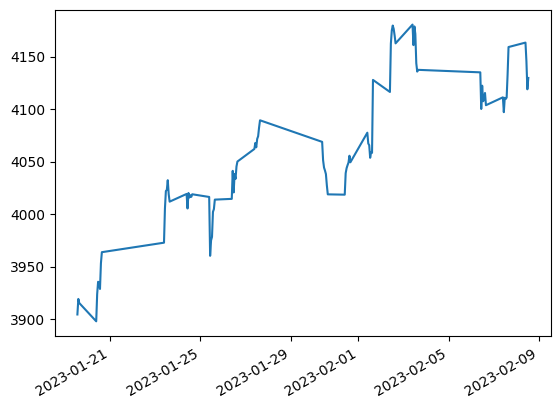

In [217]:
sar.predict(start=3300,dynamic=False)[1:
             ].plot()

In [215]:
sar.predict(start=3300,end=3954)

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


3300    3895.893763
3301    3904.305453
3302    3919.095378
3303    3915.204434
3304    3897.785616
           ...     
3950    4143.954408
3951    4144.037729
3952    4144.121081
3953    4144.204463
3954    4144.287875
Name: predicted_mean, Length: 655, dtype: float64

TypeError: 'module' object is not callable